<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#true-positives" data-toc-modified-id="true-positives-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>true positives</a></span></li><li><span><a href="#false-positives" data-toc-modified-id="false-positives-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>false positives</a></span></li><li><span><a href="#false-negatives" data-toc-modified-id="false-negatives-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>false negatives</a></span></li><li><span><a href="#true-positives" data-toc-modified-id="true-positives-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>true positives</a></span></li><li><span><a href="#false-positives" data-toc-modified-id="false-positives-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>false positives</a></span></li><li><span><a href="#false-negatives" data-toc-modified-id="false-negatives-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>false negatives</a></span></li></ul></div>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from skimage import io, color, transform, feature, exposure, filters, morphology
import my_measures # note, this was updated March 27; make sure you are using the current version! 
%matplotlib inline

In [8]:
# file paths/names

root_dir = '/Users/aucherserr/Desktop/MachineLearning/myGit/ml/mlAssignment2/plane_data/'

ci_path = root_dir + 'cropped_images_18/' # cropped images for training
l_file = root_dir + 'plane_labels_2018.csv' # csv with labels

# get labels and extract features from images

In [9]:
# all labels
plane_data = pd.read_csv(l_file)

In [10]:
dims = (30, 70) # 30% of the original size, 525 pixels

downscaled image shape: 
(30, 70)
image representation (first row of pixels): 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


example of transformation: 


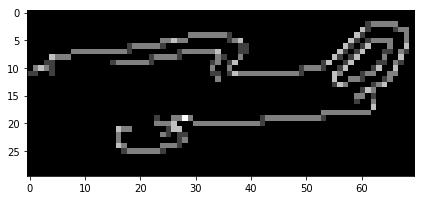

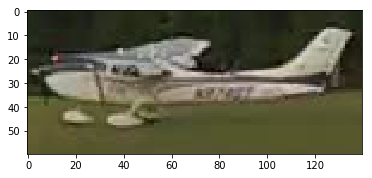

In [11]:
def image_manipulation(imname, imview=False):
    warnings.filterwarnings('ignore')
    imname = ci_path + imname + '.png'
    img_raw = io.imread(imname)
    gray = color.rgb2gray(img_raw) # remove color

    yellow = img_raw[:,:,2]
    prefiltered = filters.sobel(yellow)
    filtered = filters.scharr(prefiltered)
    canny = feature.canny(filtered, sigma = 2, low_threshold= .01)
    downscaled = transform.resize(canny, (dims[0], dims[1]))
    final_image = downscaled
    
    if imview==True:  
        plt.figure()
        io.imshow(final_image)
        plt.figure()
        plt.imshow(img_raw)
    warnings.filterwarnings('always')
    return final_image

# test the function, look at input/output
test_image = image_manipulation('2017-07-16T23+13+31_720Z', True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')


In [12]:
# construct lists for features, labels, and a crosswalk reference to image names

features_list = []
y_list = []
imnames_list = []

for index, row in plane_data.iterrows(): 
    features_list.append(image_manipulation(row['img_name']))
    y_list.append(row['plane'])
    imnames_list.append(row['img_name'])
    

In [15]:
# convert the lists to ndarrays
features = np.asarray(features_list)
Y = np.asarray(y_list)
imgs = np.asarray(imnames_list)
print('Shape of original feature representation: ')
print(features.shape)

# flatten the images ndarray to one row per image
features_flat = features.reshape((features.shape[0], -1))

print('Shape of flat feature representation: ')
print(features_flat.shape)

print('Shape of Y: ')
print(Y.shape)

print('Number of images with planes: ')
print(Y.sum())

Shape of original feature representation: 
(6758, 30, 70)
Shape of flat feature representation: 
(6758, 2100)
Shape of Y: 
(6758,)
Number of images with planes: 
101


In [25]:
# create train and test sets
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
    Y, imgs, test_size = 0.25, random_state = 15)

print('Shape of training set: ')
print(y_train.shape)
print('Number of training images that contain an airplane: ')
print(y_train.sum())

print(' ')

print('Shape of test set: ')
print(y_test.shape)
print('Number of test images that contain an airplane: ')
print(y_test.sum())

Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
82
 
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
19


In [16]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
#         print(imnames_list[img])
        warnings.filterwarnings('ignore')    
        plt.figure()
        print(imgs_test[img])
        plt.title(imgs_test[img])
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')


# train Multilayer Perceptron, a.k.a. neural network

In [18]:
from sklearn.externals import joblib
# unload pipeline pickle
nn = joblib.load('nn.pkl')

In [26]:
nn_performance_test = my_measures.BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

TEST SET: 
{'Pos': 19, 'Neg': 1671, 'TP': 17, 'TN': 1671, 'FP': 0, 'FN': 2, 'Accuracy': 0.99881656804733732, 'Precision': 1.0, 'Recall': 0.89473684210526316, 'desc': 'nn_test', 'set': 'test'}


# look at examples of neural network classifications

## true positives

2016-10-07T17+44+06_330Z
2017-07-09T15+23+27_200Z
2016-10-10T19+44+49_610Z
2016-11-17T17+57+49_310Z
2017-07-09T12+47+11_400Z
2016-11-17T18+00+45_290Z
2016-10-11T14+32+27_680Z
2017-02-04T19+20+26_310Z
2017-07-09T19+11+06_580Z
2016-10-11T11+30+52_230Z
2017-07-04T18+32+56_490Z
2016-10-07T18+23+39_200Z
2017-02-04T19+17+08_500Z
2017-07-09T18+27+26_140Z
2017-07-30T19+51+27_270Z
2017-12-01T15+56+43_120Z
2016-11-12T19+05+51_000Z


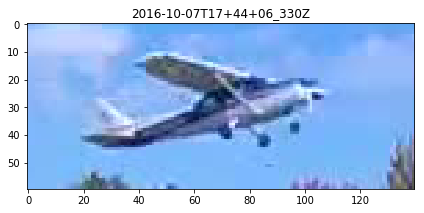

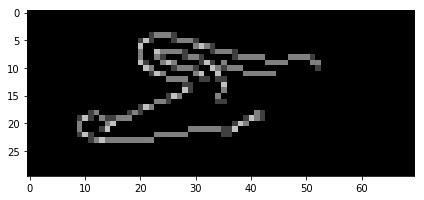

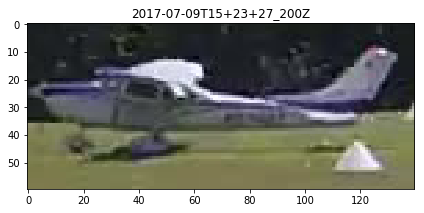

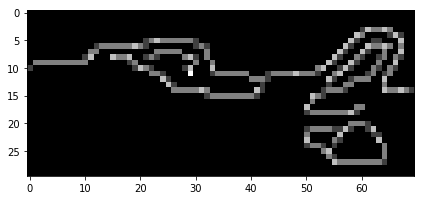

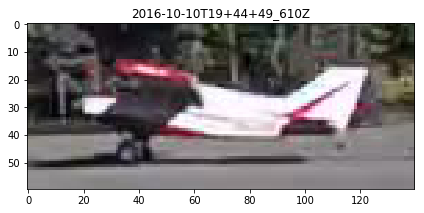

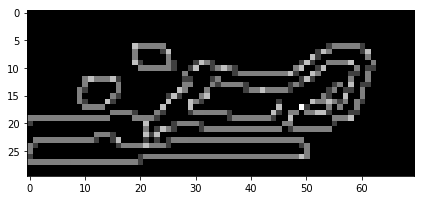

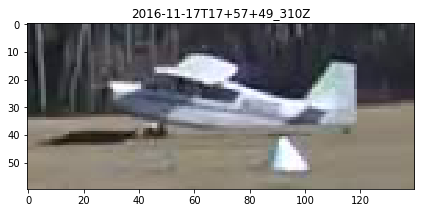

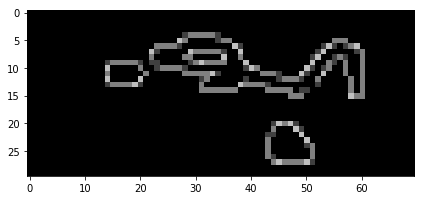

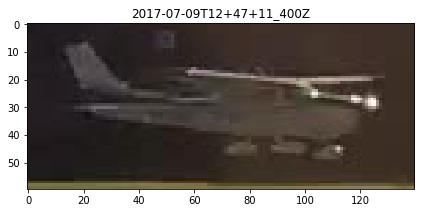

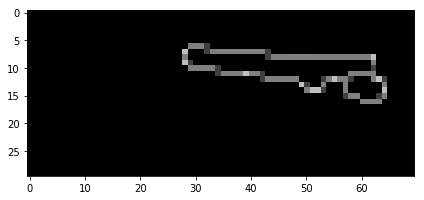

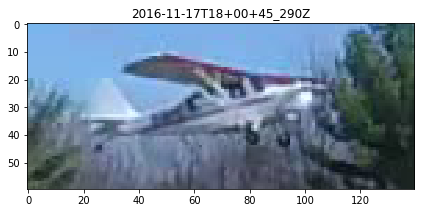

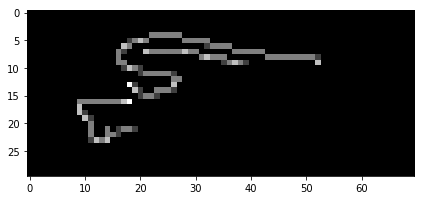

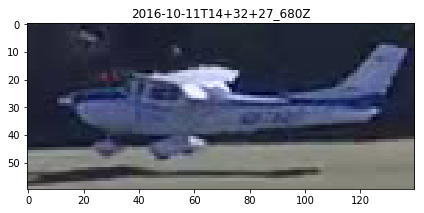

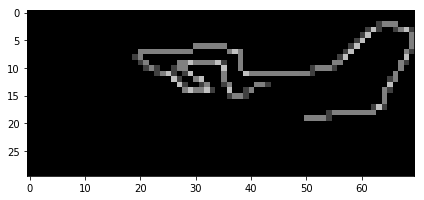

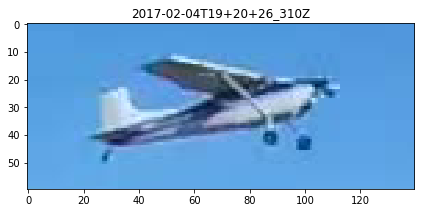

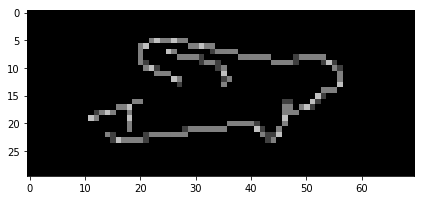

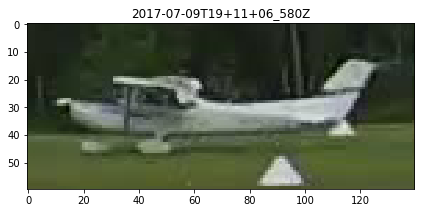

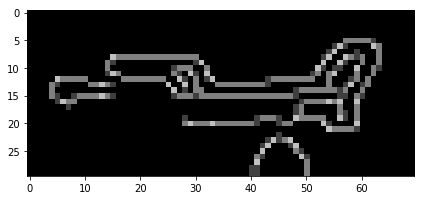

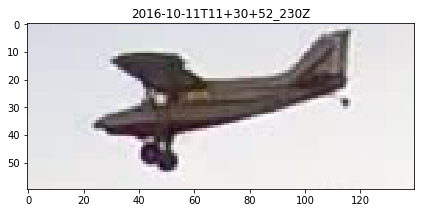

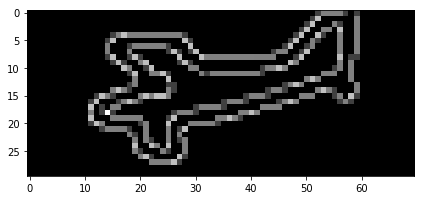

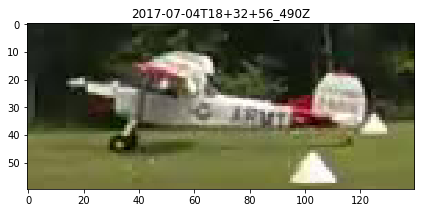

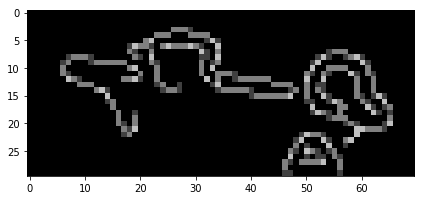

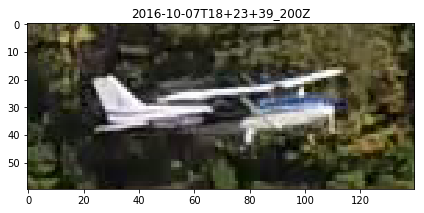

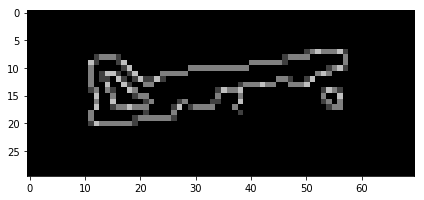

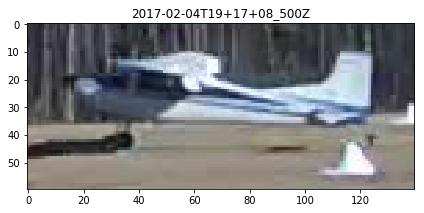

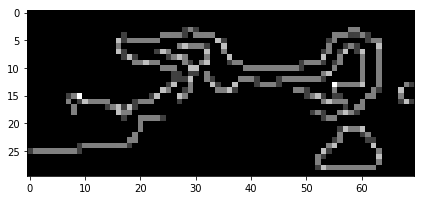

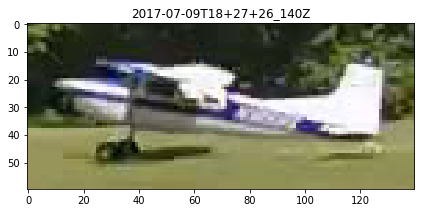

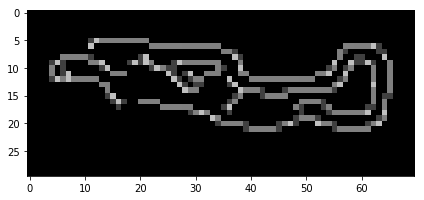

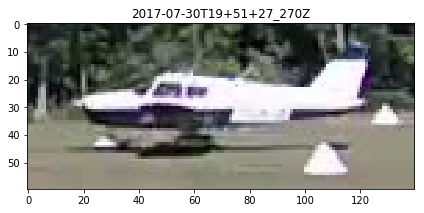

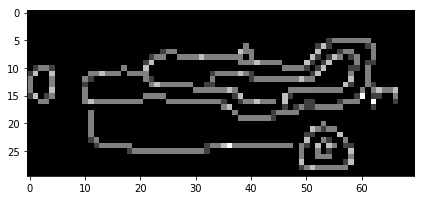

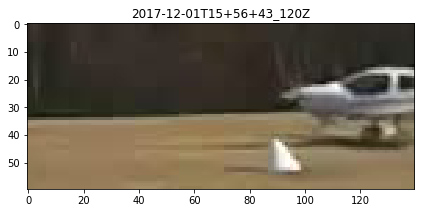

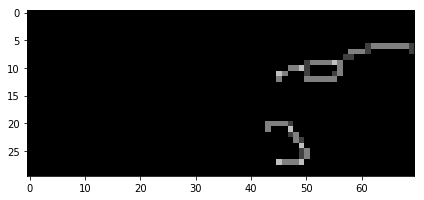

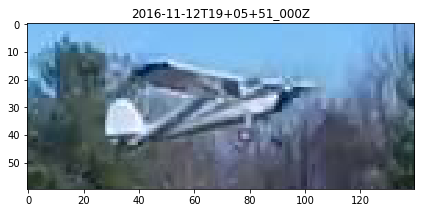

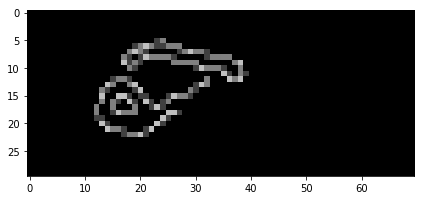

In [22]:
performance_examples('TP', nn_img_indices_to_view)

## false positives

In [23]:
performance_examples('FP', nn_img_indices_to_view)

## false negatives

2017-07-26T13+21+45_310Z
2017-08-27T12+27+15_090Z


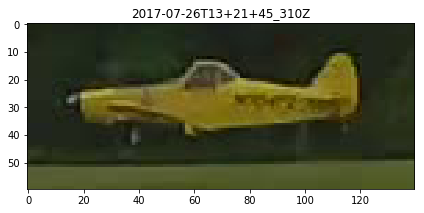

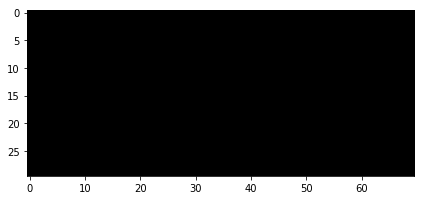

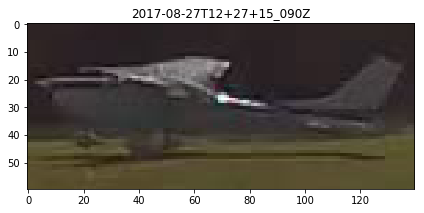

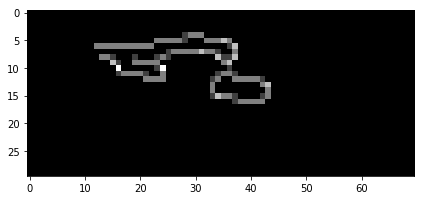

In [27]:
performance_examples('FN', nn_img_indices_to_view)